In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT
import gurobi_solvers as GB

import sim_template as sim
from importlib import reload 

In [13]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [14]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.3
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,6],[21,3],
                 [16,11],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [18, 36],[35, 41]])#,
#                  [32, 33],[48, 25]])

sub_regions = [[25,0,10,0],
               [30,10, 25, 9],
               [20,0, 40, 17],
               [50, 25, 15, 3],
               [38, 15, 45, 27]]#,
#                [50, 30, 40, 20]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 5
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.1/beta, 0.2/beta, 0.01/beta, 0.05/beta, 0.02/beta]#, 0.1/beta]
print(els)

0.0625
[1.6, 3.2, 0.16, 0.8, 0.32]


In [23]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [24]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)

Drawing 250 samples from Channel 1
Completed PredictedChannel 1
Drawing 250 samples from Channel 2
Completed PredictedChannel 2
Drawing 320 samples from Channel 3
Completed PredictedChannel 3
Drawing 320 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
[0.7975609756097561, 0.7292167869553595, 0.7984947802864772, 0.7265536723163842, 0.8126064735945485]


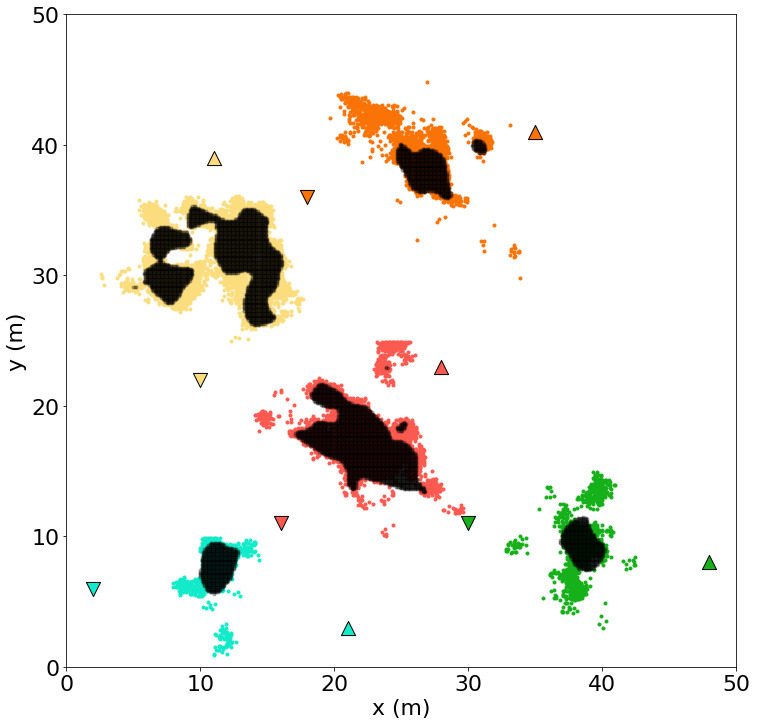

In [25]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [26]:
reload(PC)
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)
regions = dt_sys.cregions


Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
19 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
24 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
4 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions


In [28]:
pi = [2, 4, 6, 8, 10]
pi = np.array(pi)/sum(pi)
print(pi)
%store regions
#%store -r regions

[0.06666667 0.13333333 0.2        0.26666667 0.33333333]
Stored 'regions' (list)


In [ ]:
reload(SHOT)

In [29]:
#testing MICP formulation
%timeit SHOT.min_PWD(regions, pi, formulation=0)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solv

In [30]:
x_SHOT_MICP, val_SHOT_MICP = SHOT.min_PWD(regions, pi, formulation=0)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality


In [31]:
#testing MIQCP formulation
%timeit SHOT.min_PWD(regions, pi, formulation=1)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solv

In [32]:
x_SHOT_MIQCP, val_SHOT_MIQCP = SHOT.min_PWD(regions, pi, formulation=1)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality


In [ ]:
reload(GB)

In [36]:
%timeit GB.min_PWD(regions, pi, formulation = 0)


8.12 s ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
x_GB_MIQCP, val_GB_MIQCP = GB.min_PWD(regions, pi, formulation = 0, verbose = True)

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 309 rows, 80 columns and 921 nonzeros
Model fingerprint: 0xd0ecc8e7
Model has 10 quadratic constraints
Variable types: 20 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [9e-03, 9e-02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 38 rows and 0 columns
Presolve time: 0.01s
Presolved: 421 rows, 120 columns, 2131 nonzeros
Presolved model has 40 bilinear constraint(s)
Variable types: 60 continuous, 60 integer (60 binary)

Root relaxation: objective 4.215707e+00, 126 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

In [ ]:
%timeit GB.min_PWD(regions, pi, formulation = 1)

In [ ]:
x_GB_PWLC, val_GB_PWLC = GB.min_PWD(regions, pi, formulation = 1, verbose = True)

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 748 columns and 1285 nonzeros
Model fingerprint: 0xd3ec4968
Model has 10 quadratic constraints
Model has 364 general constraints
Variable types: 748 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-02, 2e+01]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [9e-03, 9e-02]
  Bounds range     [5e+00, 4e+01]
  RHS range        [1e-01, 2e+02]
Presolve added 937 rows and 399 columns
Presolve time: 0.04s
Presolved: 1456 rows, 1187 columns, 4461 nonzeros
Presolved model has 60 SOS constraint(s)
Presolved model has 40 bilinear constraint(s)
Variable types: 893 continuous, 294 integer (294 binary)

Root relaxation: objective 4.170764e+00, 530 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objectiv

 789900 152739    7.76898   69   23    7.90542    7.41700  6.18%  10.7  270s
 805168 154955     cutoff   71         7.90542    7.41851  6.16%  10.7  275s
 820557 157063    7.69565   60   20    7.90542    7.41993  6.14%  10.7  280s
 835015 159073    7.70777   73   22    7.90542    7.42161  6.12%  10.7  285s
 850318 161408     cutoff   84         7.90542    7.42333  6.10%  10.7  290s
 865285 163458    7.54126   64   34    7.90542    7.42494  6.08%  10.7  295s
 881744 165746 infeasible   71         7.90542    7.42646  6.06%  10.8  300s
H895959 167622                       7.9054230    7.42792  6.04%  10.8  304s
 896865 167841    7.62414   60   26    7.90542    7.42798  6.04%  10.8  305s
 911407 169495    7.80514   58   24    7.90542    7.42945  6.02%  10.8  310s
 924881 171497     cutoff   76         7.90542    7.43055  6.01%  10.8  315s
 939588 173783    7.76126   78   29    7.90542    7.43172  5.99%  10.8  320s
 954761 175501    7.75481   64   29    7.90542    7.43337  5.97%  10.8  325s

 2232901 288673     cutoff   57         7.90236    7.52119  4.82%  10.9  750s
 2248614 289384    7.52194   57   39    7.90236    7.52194  4.81%  10.9  755s
 2263327 290364    7.88028   58   26    7.90236    7.52266  4.80%  10.9  760s
 2277702 290953    7.52332   67   25    7.90236    7.52332  4.80%  10.9  765s
 2293579 291900 infeasible   80         7.90236    7.52409  4.79%  10.9  770s
 2308176 292817    7.85469   60   20    7.90236    7.52481  4.78%  10.9  775s
 2323931 293599 infeasible   62         7.90236    7.52581  4.76%  10.9  780s
 2338453 294497    7.85552   79   30    7.90236    7.52647  4.76%  10.9  785s
 2353039 295404     cutoff   78         7.90236    7.52715  4.75%  10.9  790s
 2367666 296140 infeasible   76         7.90236    7.52785  4.74%  10.9  795s
 2382327 296842     cutoff   70         7.90236    7.52877  4.73%  10.9  800s
 2398172 297755 infeasible   70         7.90236    7.52956  4.72%  10.9  805s
 2412337 298464    7.63574   78   26    7.90236    7.53027  4.71

In [ ]:
print(val_SHOT_MIQCP, val_SHOT_MICP, val_GB_MIQCP, val_GB_PWLC)
#val_GB_PWLC
print(x_SHOT_MIQCP)
print(x_SHOT_MICP)
print(x_GB_MIQCP)
print(x_GB_PWLC)

8.954162975991956
8.954162975991975


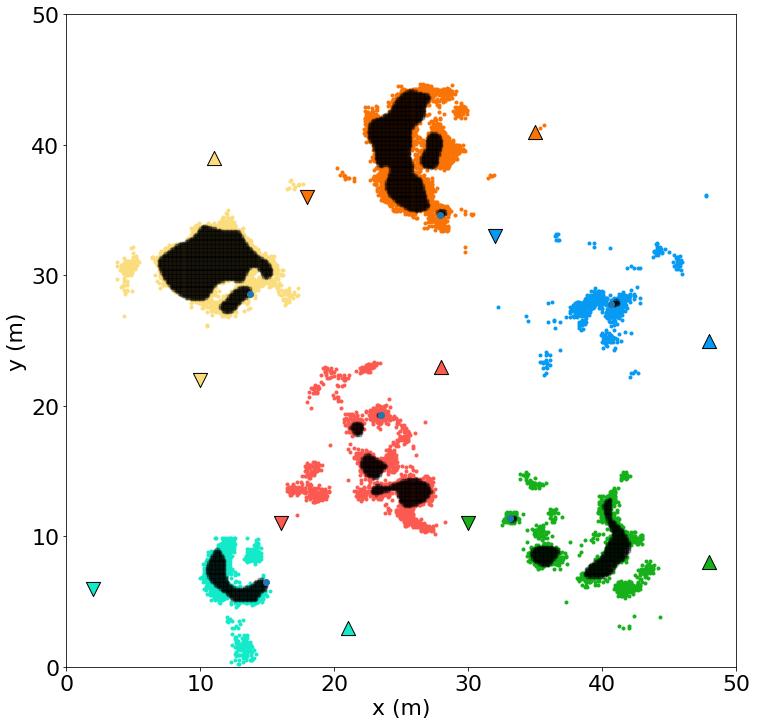

In [142]:
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
#plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [33]:
val_SHOT_MIQCP

7.905423324648161

In [34]:
val_SHOT_MICP

7.9416468936288

In [ ]:
val_GB_MIQCP